# Deep Reinforcement Learning for the TrafficLightFlow Environment


In [1]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
from TrafficLightDoubleLane import *

import time

## Environment

This is a Flow environment based on Sumo. We just used 1x1 intersection, thus immitating a very simple traffic light intersection. Environment has some InFlow parameters defined, which decide how to inject traffic into the environment in each episode.


All Vehicles are trying to immitate human behavior, and are not intelligent. Only traffic light is RL controlled.

In [2]:
# env = gym.envs.make("CartPole-v1")
InFlowProbs = (0.05, 0.05,0.15,0.15)
env = GetTrafficLightEnv(InFlowProbs, render=False,evaluate=False)
print(env.observation_space.shape)

{'bot0_0': [(['bot0_0', 'bot0_1'], 0.5), (['bot0_0', 'right1_0'], 0.5)], 'top0_1': [(['top0_1', 'top0_0'], 0.5), (['top0_1', 'left0_0'], 0.5)], 'left1_0': [(['left1_0', 'left0_0'], 0.5), (['left1_0', 'bot0_1'], 0.5)], 'right0_0': [(['right0_0', 'right1_0'], 0.5), (['right0_0', 'top0_0'], 0.5)]}
(139,)


/Users/mayankgupta/opt/anaconda3/envs/flow/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Plotting Function

This function will make it possible to analyze how the agent learns over time. The resulting plot consists of two subplots. The first one plots the total reward the agent accumulates over time, while the other plot shows a histogram of the agent's total rewards for the last 50 episodes. 

In [3]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(-200, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(-200, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

### Parameters

In [4]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 1000
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

## Static Search

Before implementing any deep learning approaches, I wrote a simple strategy where the action is staticly choosen, light will be green for 30s straight in each direction. This approach will serve as a baseline for other strategies and will make it easier to understand how to work with the agent using the Open AI Gym environment.

In [5]:
def static_search(env, episodes, 
                  title='Static Strategy'):
    """ Static strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        t = 0
        while not done:
            t+=1
            # Sample random actions
            #action = env.action_space.sample()
            action = t%20 == 0
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        print("episode: {}, total reward: {}".format(episode, total))
        plot_res(final,title)
    return final

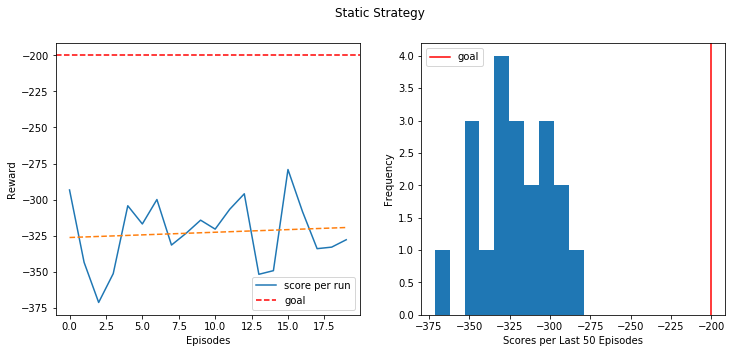

In [6]:
# Get static policy results
#

static_s = static_search(env, 20)

The plot above presents the static strategy.

## Deep Q Learning

The main idea behind Q-learning is that we have a function $Q: State \times Action \rightarrow \mathbb{R}$, which can tell the agent what actions will result in what rewards. If we know the value of Q, it is possible to construct a policy that maximizes rewards:

\begin{align}\pi(s) = \arg\!\max_a \ Q(s, a)\end{align}

However, in the real world, we don't have access to full information, that's why we need to come up with ways of approximating Q. One traditional method is creating a lookup table where the values of Q are updated after each of the agent's actions. However, this approach is slow and does not scale to large action and state spaces. Since neural networks are universal function approximators, I will train a network that can approximate $Q$.

The DQL class implementation consists of a simple neural network implemented in PyTorch that has two main methods--predict and update. The network takes the agent's state as an input and returns the Q values for each of the actions. The maximum Q value is selected by the agent to perform the next action.


In [7]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            print('new dqn initialized')
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

        

## Prediction
Here we will define helper methods to Save and Load a trained model into Disk.

In [8]:
def SaveModel(dqnModel, name):
    torch.save(dqnModel.model.state_dict(), name)

def LoadModel(dqnModel, name):
    dqnModel.model.load_state_dict(torch.load(name))
    return dqnModel


In [9]:
def prediction(model):
    """ Prediction of a pytorch model"""
    episode = 10
    InFlowProbs = (0.15, 0.1,0.15,0.1)
    env2 = GetTrafficLightEnv(InFlowProbs, render=True,evaluate=True)
    final = []
    for episode in range(episodes):
        state = env2.reset()
        done = False
        total = 0
        t = 0
        while not done:
            t+=1
            # Sample random actions
            
            q_values = model.predict(state)
            action = torch.argmax(q_values).item()
            
            # Take action and extract results
            next_state, reward, done, _ = env2.step(action)
            state = next_state
            
            # Update reward
            total += reward
            if done:
                break

        # Add to the final reward
        final.append(total)
        print("episode: {}, total reward: {}".format(episode, total))
        plot_res(final,'Prediction')
    return final

The q_learning function is the main loop for all the algorithms that follow. 
It has many parameters, namely:

- Env represents the Open Ai Gym environment that we want to solve (ex: CartPole.)
- Episodes stand for the number of games we want to play (from the beginning until the end.)
- Gamma is a discounting factor that is multiplied by future rewards to dampen these rewards' effect on the agent. It is designed to make future rewards worth less than immediate rewards.
- Epsilon represents the proportion of random actions relative to actions that are informed by existing "knowledge" that the agent accumulates during the episode. Before playing the game, the agent doesn't have any experience, so it is common to set epsilon to higher values and then gradually decrease its value.
- Eps_decay parameter indicates the speed at which the epsilon decreases as the agent learns. 0.99 comes from the original DQN paper.

I will explain other parameters later on when we will get to the corresponding agents.
The most straightforward agent updates its Q-values based on its most recent observation. It doesn't have any memory, but it learns by first exploring the environment and the gradually decreasing its epsilon value to make informed decisions:

In [10]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=64, 
               title = 'DQL', double=False, 
               n_update=10, soft=False,max_memory_size=10000, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            if (len(memory) == max_memory_size):
                memory.pop(0)
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if episode_i %100 == 0 or episode_i ==1:
            SaveModel(model, f'{title}_{episode_i}.pkl')
            
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
    
    plot_res(final, title)
    env.close()
    return final

In [11]:
# # Get DQN results
# simple_dqn = DQN(n_state, n_action, n_hidden, lr)
# simple = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.3, title='simple_dqn')

The graph above shows that the performance of the agent has significantly improved compare to Static Agent.

## Replay

The approximation of Q using one sample at a time is not very effective. The graph above is a nice illustration of that. The network managed to achieve a much better performance compared to a random agent. However, it couldn't get to the threshold line of 195 steps. I implemented experience replay to improve network stability and make sure previous experiences are not discarded but used in training.

Experience replay stores the agent's experiences in memory. Batches of experiences are randomly sampled from memory and are used to train the neural network. Such learning consists of two phases--gaining experience and updating the model. The size of the replay controls the number of experiences that are used for the network update. Memory is an array that stores the agent's state, reward, and action, as well as whether the action finished the game and the next state.



In [12]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    #old replay function
    #def replay(self, memory, size, gamma=0.9):
        #""" Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        #if len(memory) >= size:
            #states = []
            #targets = []
            # Sample a batch of experiences from the agent's memory
            #batch = random.sample(memory, size)
            
            # Extract information from the data
            #for state, action, next_state, reward, done in batch:
                #states.append(state)
                # Predict q_values
                #q_values = self.predict(state).tolist()
                #if done:
                    #q_values[action] = reward
                #else:
                    #q_values_next = self.predict(next_state)
                    #q_values[action] = reward + gamma * torch.max(q_values_next).item()
     
                #targets.append(q_values)

            #self.update(states, targets)
    
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

### replay using old replay function

In [13]:
# Get replay results
# dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
# replay = q_learning(env, dqn_replay, 
#                     episodes, gamma=.9, 
#                     epsilon=0.2, replay=True, 
#                     title='DQL with Replay')

### replay using new replay function

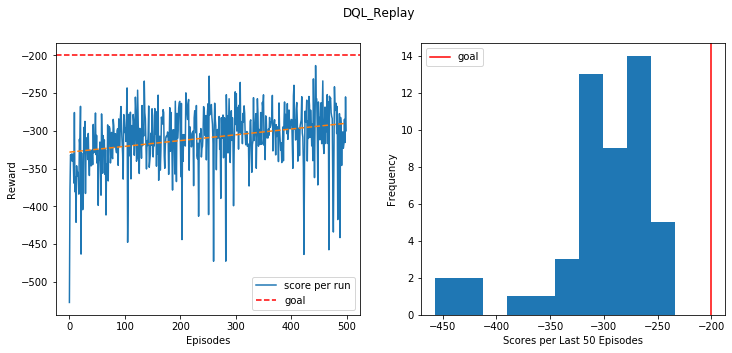

episode: 500, total reward: -299.8642908314785
Average replay time: 0.8705390396118164
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 2 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 3 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 4 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 5 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 6 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 7 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 8 seconds
Could not connect to TraCI server at localhost:60540 [Errno 61] Connection refused
 Retrying in 9 seconds
Could not connect to TraCI server at local

KeyboardInterrupt: 

In [14]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.3, replay=True, 
                    title='DQL_Replay')


In [ ]:
# print(dqn_replay.model.state_dict())

In [ ]:
# dqn_replay_loaded = DQN_replay(n_state, n_action, n_hidden, lr)
# dqn_replay_loaded = LoadModel(dqn_replay_loaded, 'dqn_replay_1.pkl')
# #print(dqn_replay.model.state_dict())
# prediction(dqn_replay_loaded)

As expected, the neural network with the replay seems to performing better and quickly converging. as It's sample efficiency is better.

## Double Q Learning

Traditional Deep Q Learning tends to overestimate the reward, which leads to unstable training and lower quality policy. Let's consider the equation for the Q value:
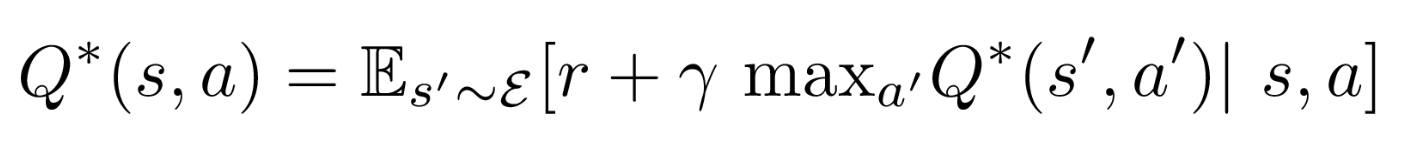
The last part of the equation takes the estimate of the maximum value. This procedure results in systematic overestimation, which introduces a maximization bias. Since Q-learning involves learning estimates from estimates, such overestimation is especially worrying.

To avoid such a situation, I will define a new target network. The Q values will be taken from this new network, which is meant to reflect the state of the main DQN. However, it doesn't have identical weights because it's only updated after a certain number of episodes. This idea has been first introduced in Hasselt et al., 2015.
The addition of the target network might slow down the training since the target network is not continuously updated. However, it should have a more robust performance over time.

n_update parameter specifies the interval, after which the target network should be updated.

In [15]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

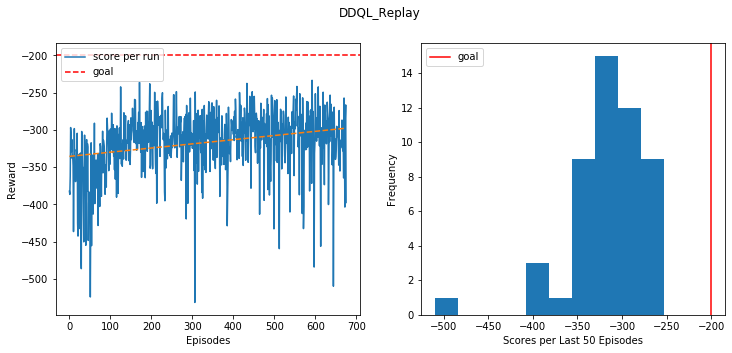

episode: 676, total reward: -397.566058742719
Average replay time: 4.6746549902583014
Reward computed: -0.9375132210723525, rl_actions: 0
Reward computed: -0.8796805942308935, rl_actions: 0
Reward computed: -0.8290107206463881, rl_actions: 0
Reward computed: -0.7829642362159733, rl_actions: 0
Reward computed: -0.7459852914397408, rl_actions: 0
Reward computed: -0.7219436874520977, rl_actions: 0
Reward computed: -0.7032713319112902, rl_actions: 0
Reward computed: -2.687343678061345, rl_actions: 1
Reward computed: -0.6798342645753657, rl_actions: 0
Reward computed: -0.6620785918369199, rl_actions: 0
Reward computed: -0.6456486411943428, rl_actions: 0
Reward computed: -0.6267672975480331, rl_actions: 0
Reward computed: -0.6100905241380729, rl_actions: 0
Reward computed: -0.5993726558975615, rl_actions: 0
Reward computed: -0.5941343274711918, rl_actions: 0
Reward computed: -0.6009451851389839, rl_actions: 0
Reward computed: -0.6095372964176132, rl_actions: 0
Reward computed: -0.64744058147

KeyboardInterrupt: 

In [16]:
# Get replay results
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.3, replay=True, double=True,
                    title='DDQL_Replay', n_update=10)


In [ ]:
# print(dqn_double.model.state_dict())
# dqn_double_loaded = DQN_double(n_state, n_action, n_hidden, lr)
# dqn_double_loaded = LoadModel(dqn_double_loaded, 'dqn_double_500.pkl')
# print(dqn_double_loaded.model.state_dict())

In [ ]:
dqn_double_loaded = DQN_double(n_state, n_action, n_hidden, lr)
dqn_double_loaded = LoadModel(dqn_double_loaded, 'dqn_double_1.pkl')
prediction(dqn_double_loaded)

Double DQL with replay has similar performance. It can be happening because our current environement is not too much complex, or non liner system and that's why Double Queue us not making much difference.

## Soft Target Update
The method used to update the target network implemented above was introduced in the original DQN paper. In this section, we will explore another well-established method of updating the target network weights. Instead of updating weights after a certain number of steps, we will incrementally update the target network after every run using the following formula:

target_weights = target_weights * (1-TAU) + model_weights * TAU

where 0 < TAU < 1

This method of updating the target network is known as “soft target network updates” and was introduced in  Lillicrap et al., 2016. Method implementation is shown below:

In [ ]:
class DQN_double_soft(DQN_double):
    def target_update(self, TAU=0.1):
        ''' Update the targer gradually. '''
        # Extract parameters  
        model_params = self.model.named_parameters()
        target_params = self.target.named_parameters()
        
        updated_params = dict(target_params)

        for model_name, model_param in model_params:
            if model_name in target_params:
                # Update parameter
                updated_params[model_name].data.copy_((TAU)*model_param.data + (1-TAU)*target_params[model_param].data)

        self.target.load_state_dict(updated_params)

In [ ]:
dqn_double_soft = DQN_double_soft(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double_soft, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='DDQL_soft_Replay', n_update=10, soft=True)

The network with soft target updates not seems to be performing good on this problem. as, there is lot of noise in each SGD udpate for this problem.

## Conclusion



## References:

(1) Reinforcement Q-Learning from Scratch in Python with OpenAI Gym. (2019). Learndatasci.com. Retrieved 9 December 2019, from https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

(2) Paszke, A., (2019). Reinforcement Learning (DQN) tutorial. Retrieved from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

(3) Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., ... & Wierstra, D. (2015). Continuous control with deep reinforcement learning. arXiv preprint arXiv:1509.02971.

(4) Van Hasselt, H., Guez, A., & Silver, D. (2016, March). Deep reinforcement learning with double q-learning. In Thirtieth AAAI conference on artificial intelligence.

(5) Wang, Z., Schaul, T., Hessel, M., Van Hasselt, H., Lanctot, M., & De Freitas, N. (2015). Dueling network architectures for deep reinforcement learning. arXiv preprint arXiv:1511.06581.

(6) Double DQN Implementation to Solve OpenAI Gym’s CartPole v-0. (2019). Medium. Retrieved 20 December 2019, from https://medium.com/@leosimmons/double-dqn-implementation-to-solve-openai-gyms-cartpole-v-0-df554cd0614d